<a href="https://colab.research.google.com/github/vlozg/speech_hmm/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech to text with HMM

- **Bài toán**: Chuyển giọng nói thành văn bản
    - **Input**: Đoạn ghi âm chứa nội dung là các số từ 0 đến 9
    - **Output**: Phân lớp của đoạn ghi âm

# Các biến thiết lập cho thử nghiệm

In [1]:
n_mfcc_ceptrum = 12
n_delta_features = 1
n_mixtures = 1
n_mfcc_features = n_mfcc_ceptrum * (1+n_delta_features)
n_mfcc_features

24

# Import và cài đặt thư viện

In [2]:
# cài lib. note: cài xong phải restart runtime
!pip install pydub
!pip install pomegranate

In [3]:
# Xác thực google để upload/download qua google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Quản lý file, folder
import os
from shutil import copyfile, rmtree
import random

# Xử lý audio
import librosa
import librosa.display
from scipy.io import wavfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pomegranate # Thư viện cho mô hình xác suất
from pomegranate import *

# Hàm xử lý âm thanh

In [4]:
#@markdown Các hàm đọc audio `read_audio` và `read_process_audio`
def minmax_scale(wave):
  return ((wave - wave.min()) / (wave.max() - wave.min()) - 0.5)

def standard_scale(wave):
  return ((wave - wave.mean()) / wave.std())

def scaleAddNoise(wave):
  return standard_scale(wave) + 0.2*np.random.normal(size=wave.shape)

'''
  Hàm đọc audio
  
  Return:
    sample_rate(int): thường cố định là 16000
    wave(np.array): waveform
'''
def read_audio(full_audio_path):
  # Bắt buộc âm thanh đọc vào phải cùng sample rate là 16000
  sample_rate, wave =  wavfile.read(full_audio_path)
  if sample_rate != 16000:
    wave, sample_rate =  librosa.load(full_audio_path, sr=16000) # Hàm đọc của librosa quá chậm, scipy nhanh gấp 5-10 lần
  else:
    wave=wave/32768 # Chuẩn hóa về số thực
  return wave, sample_rate

'''
  Hàm đọc audio, có thêm khoảng trắng ở 2 đầu audio,
  scale lại waveform và thêm white noise
  
  Return:
    sample_rate(int): thường cố định là 16000
    wave(np.array): waveform
'''
def read_process_audio(full_audio_path):
  wave, sample_rate = read_audio(full_audio_path)
  wave = np.pad(wave, (2000,2000), 'constant', constant_values=(0.0,0.0))
  wave = scaleAddNoise(wave)
  return wave, sample_rate

In [5]:
#@markdown Hàm lấy đoạn không có âm thanh (theo frame)
def unvoiced_frame(wave, sample_rate, min_len = 10):
  rms = librosa.feature.rms(y=wave)[0]
  r_normalized = standard_scale(rms)
  p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
  # Giảm dần threshold xuống nếu không đủ min_len để train HMM
  thresh = 0.5
  slice_ = p > thresh
  while (slice_.sum() < min_len):
    thresh-=0.05
    slice_ = p > thresh
  return slice_

In [6]:
#@markdown Các hàm rút trích đặc trưng MFCC
def extract_mfcc(wave, sample_rate, trim=True):
  S = librosa.feature.melspectrogram(y=wave, sr=sample_rate, n_mels=40)
  if trim:
    S = S[:,unvoiced_frame(wave, sample_rate)]
  mfccs = librosa.feature.mfcc(S=librosa.power_to_db(S), n_mfcc=n_mfcc_ceptrum+2, lifter=40)[2:,:].T/800
  return mfccs

def mfcc_delta_features(mfcc, order):
  if order==0:
    return mfcc
  dmfcc = librosa.feature.delta(mfcc, order=order)
  return dmfcc

In [7]:
#@title Hàm `full_mfcc_from_file` đọc file và tự tiền xử lý hoàn chỉnh
def full_mfcc_from_file(full_audio_path, trim=True):
  wave, sr = read_process_audio(full_audio_path)
  mfccs = extract_mfcc(wave, sr, trim)
  full_mfccs = mfccs
  if n_delta_features >= 1:
    mfccs_d1 = mfcc_delta_features(mfccs, 1)
    full_mfccs = np.hstack([full_mfccs,mfccs_d1])
  if n_delta_features >= 2:
    mfccs_d2 = mfcc_delta_features(mfccs, 2)
    full_mfccs = np.hstack([full_mfccs,mfccs_d2])
  return full_mfccs

# Hàm trực quan

In [8]:
#@markdown Hàm vẽ waveform
def plot_waveform(sample_rate, wave, ax):
  length = wave.shape[0] / sample_rate
  time = np.linspace(0., length, wave.shape[0])
  ax.plot(time, wave)

In [9]:
#@markdown Hàm vẽ spectrogram
def plot_melspec(sr, y, ax):
  S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          ax=ax)
  return img

In [10]:
#@markdown Hàm vẽ biểu đồ MFCC
def plot_mfcc(sr, y, ax, trim=False):
  mfccs = extract_mfcc(y, sr, trim).T
  rdgn = sns.diverging_palette(h_neg=235, h_pos=4, s=80, l=46, sep=3, as_cmap=True)
  sns.heatmap(mfccs, cmap=rdgn, center=0.00, cbar=True, ax=ax, vmax=1/2, vmin=-1/2)
  ax.invert_yaxis()

In [11]:
#@markdown Hàm vẽ biểu đồ đạo hàm MFCC
def plot_mfcc_1st_order(sr, y, ax, trim=False):
  mfccs = mfcc_delta_features(extract_mfcc(y, sr, trim), 1).T
  rdgn = sns.diverging_palette(h_neg=235, h_pos=4, s=80, l=46, sep=3, as_cmap=True)
  sns.heatmap(mfccs, cmap=rdgn, center=0.00, cbar=True, ax=ax, vmax=0.05, vmin=-0.05)
  ax.invert_yaxis()

In [ ]:
#@markdown Hàm vẽ biểu đồ năng lượng của âm thanh
def plot_rms(sr, y, ax):
  rms = librosa.feature.rms(y=y)[0]
  times = range(len(rms))

  ax.plot(times, rms)
  ax.axhline(0.02, color='r', alpha=0.5)
  ax.grid(True)
  ax.set(xlabel='Time', ylabel='RMS')

def plot_rms_p(sr, y, ax):
  rms = librosa.feature.rms(y=y)[0]
  times = range(len(rms))
  r_normalized = standard_scale(rms)
  p = np.exp(r_normalized) / (1 + np.exp(r_normalized))
  ax.plot(times, p, label='P[V=1|x]')
  ax.axhline(0.5, color='r', alpha=0.5, label='Descision threshold')
  ax.set(xlabel='Time')
  ax.grid(True)
  ax.legend();

# Tải pre-trained model

In [12]:
#@markdown Download pre-trained models
import os
os.system(f"wget \"https://raw.githubusercontent.com/vlozg/speech_hmm/main/pre_trained/hmm_{n_mfcc_features}_10_{n_mixtures}[023].zip\"")
os.system(f"unzip hmm_{n_mfcc_features}_10_{n_mixtures}[023].zip")

256

In [13]:
#@title Đọc model và tạo classifier `load_model_as_clf(model_id)`
# model_id có định dạng 13_<số state>_<số mixture>[số stt]
def load_model_as_clf(model_id):
  hmmModels = []
  for model_label in range(10):
    with open(f'hmm[{model_label}]_{model_id}.json','rt') as f:
      hmmModels.append(HiddenMarkovModel().from_json(f.read()))

  digit_clf = BayesClassifier(hmmModels)
  return digit_clf

In [14]:
digit_clf = load_model_as_clf(f"{n_mfcc_features}_10_{n_mixtures}[023]")

# Thử model

### Kiểm thử với file record trực tiếp

In [15]:
#@markdown Hàm `record()` thu âm ngay trong notebook
# nguồn: https://gist.github.com/korakot/c21c3476c024ad6d56d5f48b0bca92be
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from io import BytesIO
from pydub import AudioSegment

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(filename, sec=3):
  print('Start recording')
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  print('Recording stop')
  b = b64decode(s.split(',')[1])
  audio = AudioSegment.from_file(BytesIO(b))
  audio.export(filename, format="wav")
  return audio

In [48]:
filename = 'thisaudio.wav'
display(record(filename, 2))
print(f"Xin dự đoán bạn vừa đọc số: {digit_clf.predict(np.array([full_mfcc_from_file(filename)]))[0]}")

Start recording


<IPython.core.display.Javascript object>

Recording stop


Xin dự đoán bạn vừa đọc số: 4


In [49]:
wave1, sample_rate1 = read_process_audio(filename)

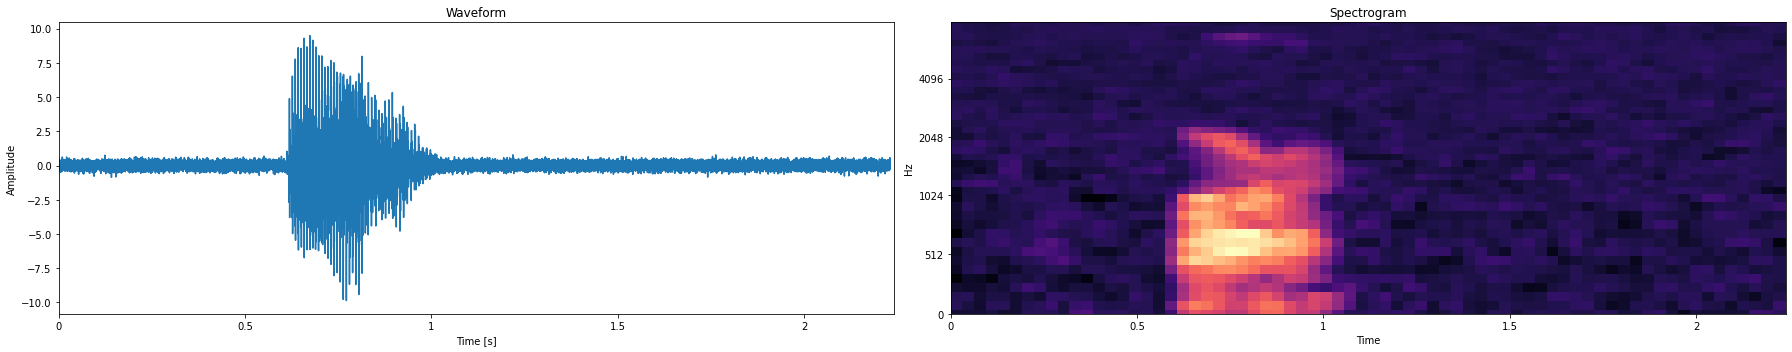

In [50]:
#@markdown ## Waveform and Spectrogram
fig, axs = plt.subplots(ncols=2, sharex='all')
fig.set_size_inches(25, 5)
axs[0].set(title='Waveform', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='Spectrogram', xlabel="Time [s]", ylabel="Hz")
plot_waveform(sample_rate1, wave1, axs[0])
img = plot_melspec(sample_rate1, wave1, axs[1])
fig.tight_layout()
fig.show()

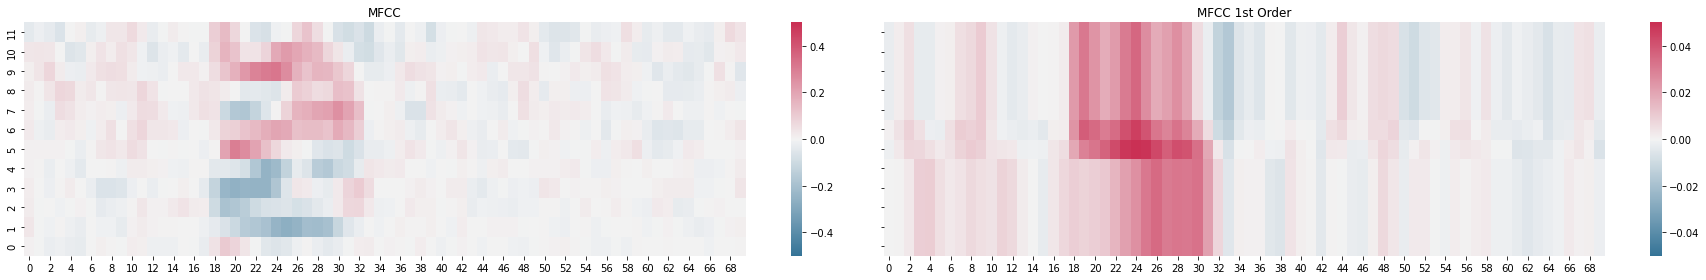

In [51]:
#@markdown ## MFCC and 1st order MFCC
fig, axs = plt.subplots(ncols=2, sharey='all', sharex='all')
fig.set_size_inches(25, 4)
axs[0].set(title='MFCC')
plot_mfcc(sample_rate1, wave1, axs[0])
axs[1].set(title='MFCC 1st Order')
plot_mfcc_1st_order(sample_rate1, wave1, axs[1])
fig.tight_layout()
fig.show()

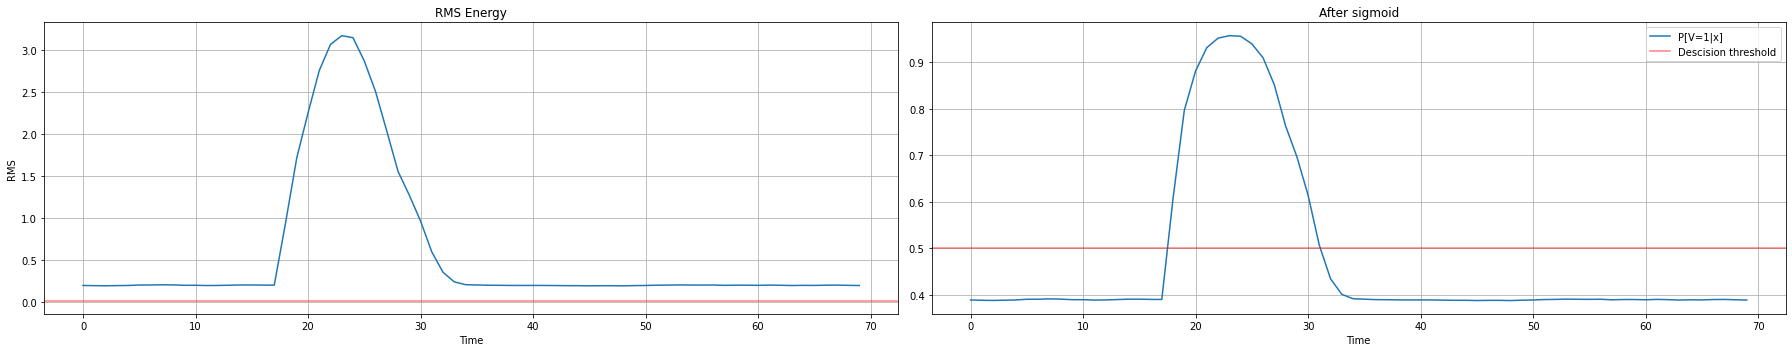

In [52]:
#@markdown ## RMS Energy and after sigmoid
fig, axs = plt.subplots(ncols=2, sharex='all')
fig.set_size_inches(25, 5)
axs[0].set(title='RMS Energy', xlabel="Time [s]", ylabel="Amplitude")
axs[1].set(title='After sigmoid', xlabel="Time [s]")
plot_rms(sample_rate1, wave1, axs[0])
plot_rms_p(sample_rate1, wave1, axs[1])
fig.tight_layout()
fig.show()

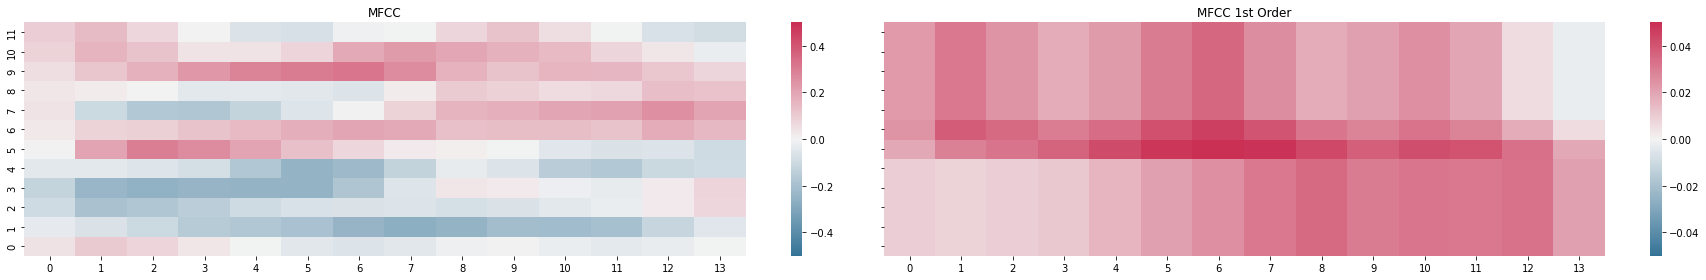

In [53]:
#@markdown ## Sau cắt bỏ khoảng trắng
fig, axs = plt.subplots(ncols=2, sharey='all', sharex='all')
fig.set_size_inches(25, 4)
axs[0].set(title='MFCC')
plot_mfcc(sample_rate1, wave1, axs[0], True)
axs[1].set(title='MFCC 1st Order')
plot_mfcc_1st_order(sample_rate1, wave1, axs[1], True)
fig.tight_layout()
fig.show()